Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [ ]:
import os
import requests
import pandas as pd
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0
    
    # Conversion degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Conversion from km to m
    distance = R * c * 1000  
    return distance


url = "http://api.citybik.es/v2/networks/velib"
response = requests.get(url)

if response.status_code == 200:
    data = response.json()
    stations = data['network']['stations']
    
    station_details = []
    for station in stations:
        lat = station['latitude']
        lon = station['longitude']
        free_bikes = station['free_bikes']
        
        station_details.append({
            'latitude': lat,
            'longitude': lon,
            'free_bikes': free_bikes
        })
    
    df_bikes = pd.DataFrame(station_details)
else:
    print(f"Error: {response.status_code}")

yelp_api_key = os.getenv('YELP_API_KEY')
lat, lon = 48.879359419425, 2.3665961623192
yelp_url = f"https://api.yelp.com/v3/businesses/search?latitude={lat}&longitude={lon}&radius=1000"

headers = {
    'Authorization': f'Bearer {yelp_api_key}',
    'Accept': 'application/json'
}

response = requests.get(yelp_url, headers=headers)

if response.status_code == 200:
    data = response.json()

    places_list = []
    if 'businesses' in data:
        for place in data['businesses']:
            name = place.get('name', 'No name')
            location = place.get('location', {})
            address = ", ".join([str(location.get('address1', 'No address provided')),
                                 str(location.get('address2', '')),
                                 str(location.get('address3', ''))]).strip(', ')
            city = location.get('city', 'No city provided')
            country = location.get('country', 'No country provided')
            rating = place.get('rating', 'No rating available')
            coordinates = place.get('coordinates', {})
            lat = coordinates.get('latitude')
            lon = coordinates.get('longitude')
            
            if lat is not None and lon is not None:
                places_list.append({
                    'Name': name,
                    'Address': address,
                    'City': city,
                    'Country': country,
                    'Rating': rating,
                    'latitude': lat,
                    'longitude': lon
                })
            else:
                print(f"Missing latitude/longitude for place: {name}")
    
    df_places = pd.DataFrame(places_list)
else:
    print(f"Error: {response.status_code}")


# Drop rows with missing latitude or longitude
df_bikes.dropna(subset=['latitude', 'longitude'], inplace=True)
df_places.dropna(subset=['latitude', 'longitude'], inplace=True)

# Maximum distance threshold = 100 meters
max_distance = 100  

merged_data = []

for bike_index in range(len(df_bikes)):
    bike_lat = df_bikes.iloc[bike_index]['latitude']
    bike_lon = df_bikes.iloc[bike_index]['longitude']
    free_bikes = df_bikes.iloc[bike_index]['free_bikes']
    
    for place_index in range(len(df_places)):
        place_lat = df_places.iloc[place_index]['latitude']
        place_lon = df_places.iloc[place_index]['longitude']
        
        #Distance between the bike station and the place
        distance = haversine(bike_lat, bike_lon, place_lat, place_lon)
        
        # Check for distance is <= 100m 
        if distance <= max_distance:
            merged_data.append({
                'latitude': bike_lat,
                'longitude': bike_lon,
                'free_bikes': free_bikes,
                'Name': df_places.iloc[place_index]['Name'],
                'Address': df_places.iloc[place_index]['Address'],
                'City': df_places.iloc[place_index]['City'],
                'Country': df_places.iloc[place_index]['Country'],
                'Rating': df_places.iloc[place_index]['Rating'],
                'Distance (m)': distance
            })

# Convert the merged data into a DataFrame
df_merged = pd.DataFrame(merged_data)

# Show the merged DataFrame
print("\nMerged DataFrame:")
print(df_merged)


output_file_path = os.path.join('data', 'merged_data.csv')
df_merged.to_csv(output_file_path, index=False)



Merged DataFrame:
     latitude  longitude  free_bikes                       Name  \
0   48.882030   2.363562         2.0                   La Bulle   
1   48.881270   2.368186         2.0             Point Ephémère   
2   48.874330   2.362123         3.0         Les Enfants Perdus   
3   48.870948   2.361205         2.0                  Assanabel   
4   48.872871   2.354215        11.0                      Le 52   
5   48.877485   2.366007         1.0                   Le Valmy   
6   48.877485   2.366007         1.0  Street Bangkok Local Food   
7   48.877568   2.369879         7.0            Generator Paris   
8   48.857059   2.341798        16.0  Le Réfectoire - Foodtruck   
9   48.879359   2.366596         0.0                      FLESH   
10  48.879359   2.366596         0.0               Kheak & Vero   
11  48.879359   2.366596         0.0                  Bizz' Art   
12  48.879359   2.366596         0.0           Le Cafe Bizz'art   

                               Address   C

Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

EDA Question 1: 
Analyze the relationship between bike station demand and proximity to popular businesses or areas

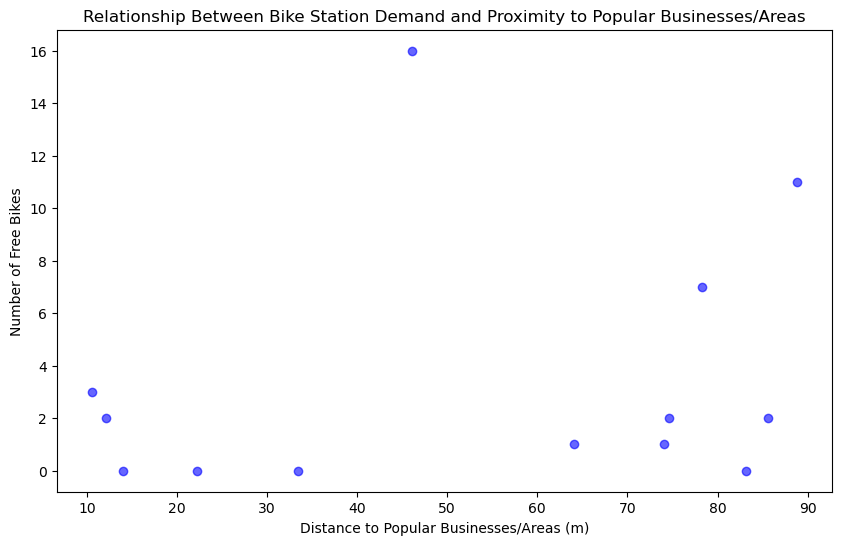

In [13]:
import matplotlib.pyplot as plt

data = pd.read_csv('data/merged_data.csv')

# Scatter plot to visualize the relationship between free_bikes and Distance (m)
plt.figure(figsize=(10, 6))
plt.scatter(data['Distance (m)'], data['free_bikes'], color='blue', alpha=0.6)

plt.title('Relationship Between Bike Station Demand and Proximity to Popular Businesses/Areas')
plt.xlabel('Distance to Popular Businesses/Areas (m)')
plt.ylabel('Number of Free Bikes')
plt.show()

Pattern Observed: Popular places tend to have fewer free bikes available, suggesting higher demand. More bikes are available in less crowded area. 

EDA Question 2: What's the name of the restaurant has the highest rating in the city and which restaurant has the lowest?


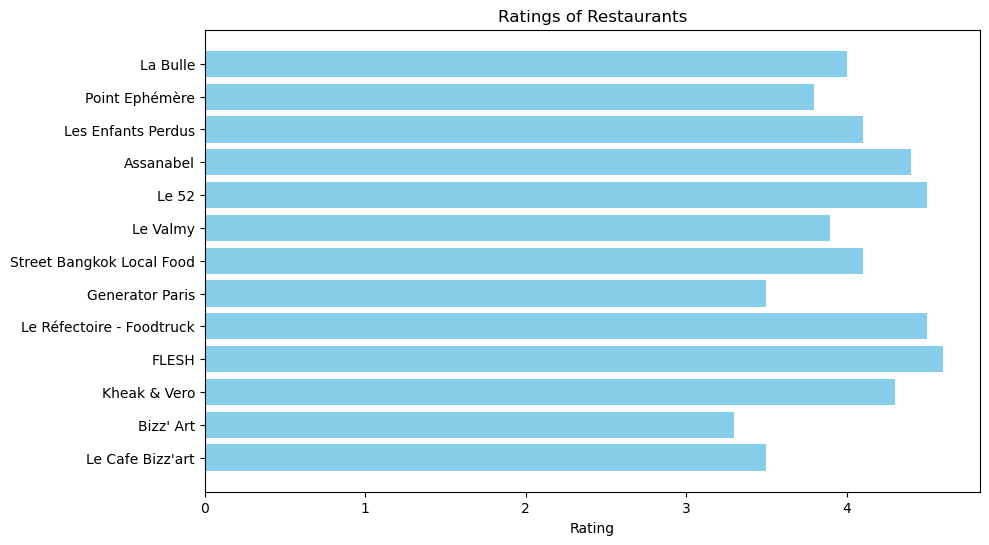

The restaurant with the highest rating is FLESH with a rating of 4.6.
The restaurant with the lowest rating is Bizz' Art with a rating of 3.3.


In [ ]:
highest_rating = data.loc[data['Rating'].idxmax()]
lowest_rating = data.loc[data['Rating'].idxmin()]

# Bar chart for Ratings
plt.figure(figsize=(10, 6))
plt.barh(data['Name'], data['Rating'], color='skyblue')
plt.xlabel('Rating')
plt.title('Ratings of Restaurants')
plt.gca().invert_yaxis()  
plt.show()

print(f"The restaurant with the highest rating is {highest_rating['Name']} with a rating of {highest_rating['Rating']}.")
print(f"The restaurant with the lowest rating is {lowest_rating['Name']} with a rating of {lowest_rating['Rating']}.")

Pattern Observed: The restaurant with the highest rating is FLESH with a rating of 4.6 and the restaurant with the lowest rating is Bizz' Art with a rating of 3.3.


EDA Question 3: What is the average number of free bikes available across Paris?

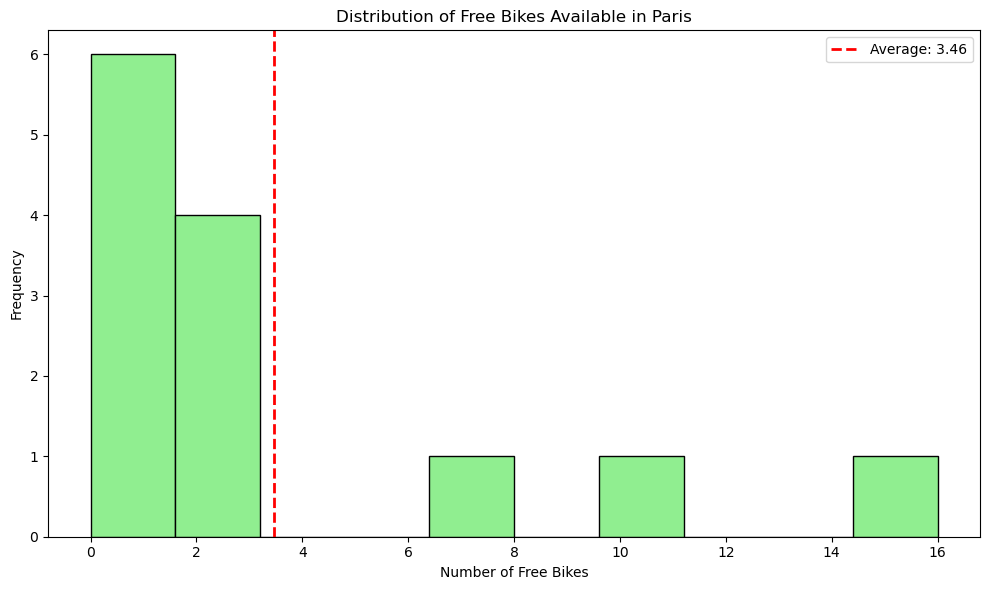

The average number of free bikes available across Paris is 3.46


In [21]:
average_bikes = data['free_bikes'].mean()

plt.figure(figsize=(10, 6))
plt.hist(data['free_bikes'], bins=10, color='lightgreen', edgecolor='black')

plt.axvline(average_bikes, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_bikes:.2f}')


plt.title('Distribution of Free Bikes Available in Paris')
plt.xlabel('Number of Free Bikes')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

print(f"The average number of free bikes available across Paris is {average_bikes:.2f}")

Pattern Observed: The average number of free bikes available across Paris is 3.46


# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [22]:
import sqlite3

db_path = 'data/bike_station_data.db'
conn = sqlite3.connect(db_path)

# Insert the merged DataFrame into the SQLite database
df_merged.to_sql('bike_stations', conn, if_exists='replace', index=False)

conn.close()
print(f"Success!")


Success!


Look at the data before and after the join to validate your data.

In [23]:
print("Bike Stations Data")
print(df_bikes.head()) 

print("\nPlaces Data")
print(df_places.head()) 

print("\nMerged Data")
print(df_merged.head())  

print('\n')

# Compare rows before and after merging
print(f"Number of rows in Bike Stations Data: {len(df_bikes)}")
print(f"Number of rows in Places Data: {len(df_places)}")
print(f"Number of rows in Merged Data: {len(df_merged)}")

#Sort by rating
popular_places = df_merged[df_merged['Rating'] >= 4.0]
print("\nStations close to popular places (rating >= 4.0):")
print(popular_places.head())


Bike Stations Data
    latitude  longitude  free_bikes
0  48.888559   2.264200          10
1  48.836591   2.293056           4
2  48.864186   2.378317           3
3  48.871257   2.486581          13
4  48.831633   2.329312           3

Places Data
                         Name                        Address   City Country  \
0  Restaurant le Robinet d'Or            7 rue Eugène Varlin  Paris      FR   
1                    Le Valmy  145 quai de Valmy, None, None  Paris      FR   
2                       FLESH     23 rue Louis Blanc, , None  Paris      FR   
3   Street Bangkok Local Food            3 rue Eugène Varlin  Paris      FR   
4              Latinogourmand             233 rue la Fayette  Paris      FR   

   Rating   latitude  longitude  
0     4.1  48.878147   2.364746  
1     3.9  48.877615   2.365153  
2     4.6  48.880090   2.366840  
3     4.1  48.877830   2.365140  
4     4.5  48.882180   2.367550  

Merged Data
    latitude  longitude  free_bikes                Name  \
0

# Cleaning Data for Modelling

In [ ]:
data = pd.read_csv('data/merged_data.csv')

# duplicate rows
data = data.drop_duplicates(subset=["latitude", "longitude", "Name"])

# Capitalization
data['Name'] = data['Name'].str.title()

# Extra spaces and capitalization
data['Address'] = data['Address'].str.strip().str.title()

# Positive distance
data = data[data['Distance (m)'] >= 0]

output_path = os.path.join('data', 'cleaned_data.csv')
data.to_csv(output_path, index=False)